In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import regex as re

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Dropout, RepeatVector
from keras.metrics import RootMeanSquaredError
%matplotlib inline

Using TensorFlow backend.


### Loading Preprocessed Dataset

In [559]:
df = pd.read_csv('C:/Users/Gj/Documents/Git/macedonian_stock_exchange_market/tmp/mse_raw.csv', parse_dates=['date', 'start_date'], index_col='Unnamed: 0')

In [560]:
df.head(5)

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09


### setting RNN ALK dataset for training, validation and test

In [4]:
alk_df = df[df.stock_id == 'ALK']

In [5]:
alk_df.columns

Index(['stock_id', 'date', 'open', 'high', 'low', 'average', 'close', 'volume',
       'quantity', 'change %', 'volume total', 'start_date'],
      dtype='object')

### split dataset

In [6]:
#Create a new dataframe with only closing price column
close_price = alk_df['close']

#Convert the dataframe into numpy array
close_price = close_price.values

In [7]:
close_price.shape

(8630,)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
scaled_df = scaler.fit_transform(close_price.reshape(len(close_price), 1))

In [10]:
scaled_df

array([[0.04175824],
       [0.04175824],
       [0.04175824],
       ...,
       [0.86373626],
       [0.86373626],
       [0.85714286]])

### univariate sequence

In [11]:
# split a univariate sequence into samples with one day prediciton
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(scaled_df, n_steps)
# summarize the data
for i in range(3):
    print(X[i], y[i])

[[0.04175824]
 [0.04175824]
 [0.04175824]] [0.04175824]
[[0.04175824]
 [0.04175824]
 [0.04175824]] [0.04175824]
[[0.04175824]
 [0.04175824]
 [0.04175824]] [0.04029304]


### Vanilla LSTM, one day prediciton

In [13]:
X_train, X_valid, X_test = X[:int(len(X)-60),], X[int(len(X)-60):int(len(X)-1),], X[int(len(X)-1):,]
y_train, y_valid, y_test = y[:int(len(X)-60),], y[int(len(X)-60):int(len(X)-1),], y[int(len(X)-1):,]

In [14]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8567, 3, 1), (59, 3, 1), (1, 3, 1), (8567, 1), (59, 1), (1, 1))

In [15]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [16]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
rmse = RootMeanSquaredError()

In [17]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [18]:
my_callback1 = ModelCheckpoint('vanila_best.pt', verbose=1, save_best_only=True, mode='min', monitor='val_loss')
my_callback2 = EarlyStopping(patience=15)

my_callbacks = [my_callback1, my_callback2]

In [19]:
# fit model
history = model.fit(X_train, y_train, epochs=50, callbacks=my_callbacks, validation_data=[X_valid, y_valid])

Train on 8567 samples, validate on 59 samples
Epoch 1/50
8567/8567 [==============================] - 2s 257us/step - loss: 0.0139 - val_loss: 3.3662e-04

Epoch 00001: val_loss improved from inf to 0.00034, saving model to vanila_best.pt
Epoch 2/50
8567/8567 [==============================] - 2s 184us/step - loss: 7.8924e-05 - val_loss: 1.0230e-04

Epoch 00002: val_loss improved from 0.00034 to 0.00010, saving model to vanila_best.pt
Epoch 3/50
8567/8567 [==============================] - 2s 185us/step - loss: 7.6187e-05 - val_loss: 9.7811e-05

Epoch 00003: val_loss improved from 0.00010 to 0.00010, saving model to vanila_best.pt
Epoch 4/50
8567/8567 [==============================] - 2s 190us/step - loss: 7.5877e-05 - val_loss: 5.5492e-05

Epoch 00004: val_loss improved from 0.00010 to 0.00006, saving model to vanila_best.pt
Epoch 5/50
8567/8567 [==============================] - 2s 189us/step - loss: 7.5668e-05 - val_loss: 7.9617e-05

Epoch 00005: val_loss did not improve from 0.0000

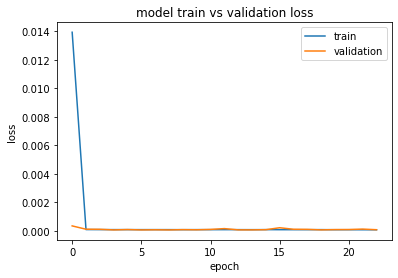

In [20]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [21]:
yhat = model.predict(X_test, verbose=0)

In [22]:
y_actual = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(yhat)

In [23]:
np.sqrt(mean_squared_error(y_actual, y_pred))

46.7890625

### Stacked LSTM, one day prediciton

In [24]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [25]:
# fit model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    callbacks=my_callbacks, 
                    validation_data=[X_valid, y_valid])

Train on 8567 samples, validate on 59 samples
Epoch 1/50
8567/8567 [==============================] - 4s 445us/step - loss: 0.0102 - val_loss: 2.2322e-04

Epoch 00001: val_loss did not improve from 0.00005
Epoch 2/50
8567/8567 [==============================] - 2s 284us/step - loss: 1.0777e-04 - val_loss: 7.9504e-05

Epoch 00002: val_loss did not improve from 0.00005
Epoch 3/50
8567/8567 [==============================] - 2s 287us/step - loss: 9.8058e-05 - val_loss: 7.2033e-05

Epoch 00003: val_loss did not improve from 0.00005
Epoch 4/50
8567/8567 [==============================] - 2s 290us/step - loss: 1.0802e-04 - val_loss: 1.4977e-04

Epoch 00004: val_loss did not improve from 0.00005
Epoch 5/50
8567/8567 [==============================] - 2s 288us/step - loss: 1.0186e-04 - val_loss: 1.0204e-04

Epoch 00005: val_loss did not improve from 0.00005
Epoch 6/50
8567/8567 [==============================] - 2s 290us/step - loss: 9.5288e-05 - val_loss: 7.3235e-04

Epoch 00006: val_loss did

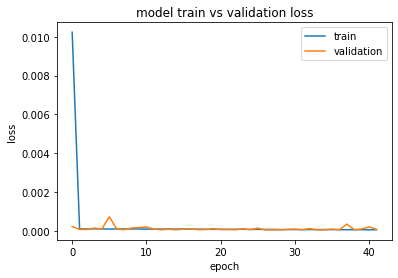

In [26]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
yhat = model.predict(X_test, verbose=0)

In [28]:
y_actual = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(yhat)
np.sqrt(mean_squared_error(y_actual, y_pred))

31.44140625

### univariate sequence many to many

In [539]:
# function that segments the data
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [540]:
# choose a number of time steps
n_steps_in, n_steps_out = 360, 30
n_features = 1

# split the data into samples
X, y = split_sequence(scaled_df, n_steps_in, n_steps_out)

# print the first 3 samples for trainX and trainY
for i in range(3):
    print(X[i], "\n Y: "  ,y[i])

[[0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04029304]
 [0.04029304]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03

In [541]:
X.shape, y.shape

((8241, 360, 1), (8241, 30, 1))

In [542]:
X_train, X_valid, X_test = X[:int(len(X)-60),], X[int(len(X)-60):int(len(X)-30),], X[int(len(X)-30):,]
y_train, y_valid, y_test = y[:int(len(X)-60),], y[int(len(X)-60):int(len(X)-30),], y[int(len(X)-30):,]

In [543]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8181, 360, 1),
 (30, 360, 1),
 (30, 360, 1),
 (8181, 30, 1),
 (30, 30, 1),
 (30, 30, 1))

In [544]:
# There are 30 (n_steps_out) predictions for each data point. 
# Thus, we need to take the predicitons on each 'n_steps_out' step 
#X_valid, y_valid = X_valid[:,:n_steps_out], y_valid[:,:n_steps_out]
#X_test, y_test = X_test[:,:n_steps_out], y_test[:,:n_steps_out]

In [545]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8181, 360, 1),
 (30, 360, 1),
 (30, 360, 1),
 (8181, 30, 1),
 (30, 30, 1),
 (30, 30, 1))

In [546]:
# define model
model_many_to_many = Sequential()
model_many_to_many.add(LSTM(30, activation='relu', input_shape=(n_steps_in, n_features)))
model_many_to_many.add(RepeatVector(n_steps_out))
model_many_to_many.add(Dropout(0.2))
model_many_to_many.add(LSTM(5, activation='relu', input_shape=(n_steps_in, n_features)))
model_many_to_many.add(RepeatVector(n_steps_out))
model_many_to_many.add(Dropout(0.2))
model_many_to_many.add(Dense(25))
model_many_to_many.add(Dense(25))
model_many_to_many.add(Dense(1))
model_many_to_many.compile(optimizer='adam', loss='mse')
print(model_many_to_many.summary())

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 30)                3840      
_________________________________________________________________
repeat_vector_54 (RepeatVect (None, 30, 30)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 5)                 720       
_________________________________________________________________
repeat_vector_55 (RepeatVect (None, 30, 5)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 5)             0         
_________________________________________________________________
dense_106 (Dense)            (None, 30, 25)          

In [547]:
my_callback1 = ModelCheckpoint('best_score_30_days.pt', verbose=1, save_best_only=True, mode='min', monitor='val_loss')
my_callback2 = EarlyStopping(patience=2)

my_callbacks = [my_callback1, my_callback2]

In [548]:
history = model_many_to_many.fit(X_train, y_train,
                                 epochs=5,
                                 batch_size=3,
                                 callbacks=my_callbacks,
                                 verbose=1,
                                 validation_data=(X_valid, y_valid))

Train on 8181 samples, validate on 30 samples
Epoch 1/5
8181/8181 [==============================] - 1111s 136ms/step - loss: 0.0085 - val_loss: 0.0028

Epoch 00001: val_loss improved from inf to 0.00283, saving model to best_score_30_days.pt
Epoch 2/5
8181/8181 [==============================] - 1128s 138ms/step - loss: 0.0077 - val_loss: 0.0014

Epoch 00002: val_loss improved from 0.00283 to 0.00139, saving model to best_score_30_days.pt
Epoch 3/5
8181/8181 [==============================] - 1113s 136ms/step - loss: 0.0075 - val_loss: 7.7432e-04

Epoch 00003: val_loss improved from 0.00139 to 0.00077, saving model to best_score_30_days.pt
Epoch 4/5
8181/8181 [==============================] - 1100s 134ms/step - loss: 0.0057 - val_loss: 0.0058

Epoch 00004: val_loss did not improve from 0.00077
Epoch 5/5
8181/8181 [==============================] - 1121s 137ms/step - loss: 0.0057 - val_loss: 5.8773e-04

Epoch 00005: val_loss improved from 0.00077 to 0.00059, saving model to best_score

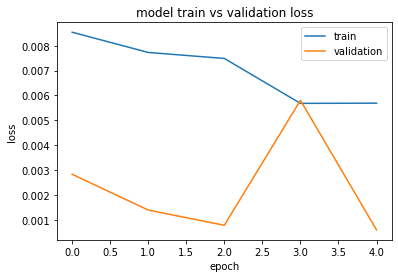

In [549]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [550]:
# make predictions
yhat = model_many_to_many.predict(X_test, verbose=0)

In [551]:
yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1],1)

In [552]:
y_actual = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(yhat)
np.sqrt(mean_squared_error(y_actual, y_pred))

526.5648914545658

In [553]:
y_train_pred = model_many_to_many.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(y_train_pred.shape[0]*y_train_pred.shape[1],1))

In [554]:
y_valid_pred = model_many_to_many.predict(X_valid)
y_valid_pred = scaler.inverse_transform(y_valid_pred.reshape(y_valid_pred.shape[0]*y_valid_pred.shape[1],1))

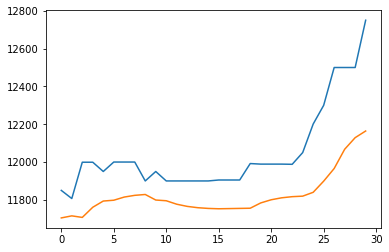

In [555]:
# plot the test data and predicitons
plt.plot(y_actual[::30])
plt.plot(y_pred[::30])
plt.show()

In [556]:
y_actual[::30][-1], y_pred[::30][-1]

(array([12750.]), array([12164.129], dtype=float32))

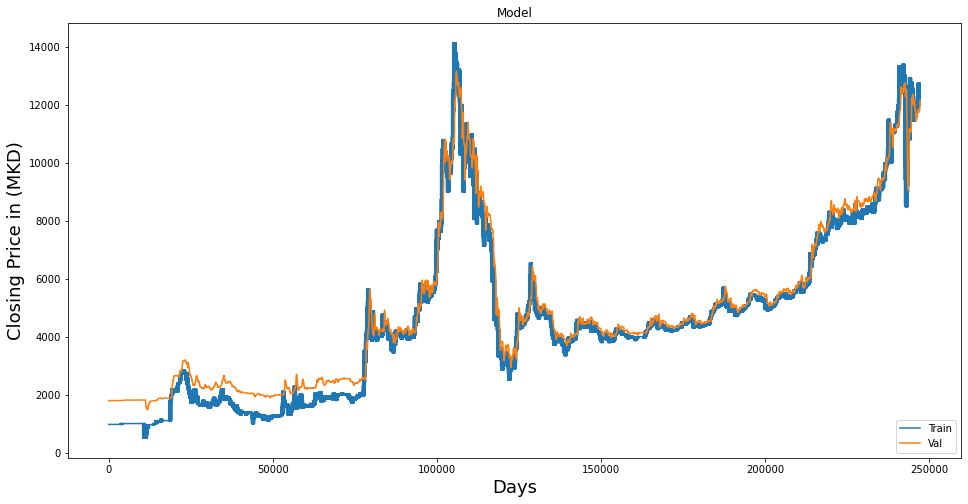

In [557]:
#plot the data
train_actual = scaler.inverse_transform(y_train.reshape(y_train.shape[0]*y_train.shape[1],1))
valid_actual = scaler.inverse_transform(y_valid.reshape(y_valid.shape[0]*y_valid.shape[1],1))
test_actual = scaler.inverse_transform(y_test.reshape(y_test.shape[0]*y_test.shape[1],1))
all_actual = np.concatenate([train_actual, valid_actual, test_actual], axis=0)
all_prediction = np.concatenate([y_train_pred, y_valid_pred, y_pred], axis=0)
#valid['Predictions'] = predictions
#Visualize the Plot
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Closing Price in (MKD)', fontsize=18)
plt.plot(all_actual)
plt.plot(all_prediction)
plt.legend(['Train','Val'], loc= 'lower right')
plt.show()

In [558]:
# calculate root mean squared error on the train, validation and test data
train_score = np.sqrt(mean_squared_error(train_actual, y_train_pred))
print('Train RMSE: %.2f RMSE' % (train_score))
valid_score = np.sqrt(mean_squared_error(valid_actual, y_valid_pred))
print('Validation RMSE: %.2f RMSE' % (valid_score))
test_score = np.sqrt(mean_squared_error(test_actual, y_pred))
print('Test RMSE: %.2f RMSE' % (test_score))

Train RMSE: 535.89 RMSE
Validation RMSE: 330.92 RMSE
Test RMSE: 526.56 RMSE
